# ⚡️ Energy-Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

The code is adapted from the excellent ['Deep Energy-Based Generative Models' tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) created by Phillip Lippe.

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

from utils import display, sample_batch
import random

## 0. Parameters <a name="parameters"></a>

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [ ]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [ ]:
# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

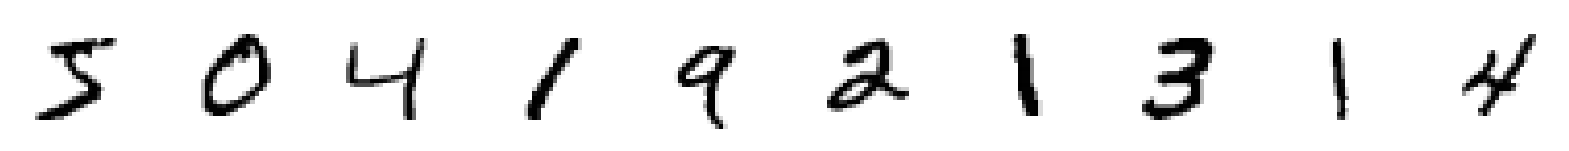

In [27]:
# Show some
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Build the EBM network <a name="train"></a>

In [ ]:
#функция энергии - нейронная сеть, которая трансформирует входное изображение в скалярное значение
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input) #функция энергии стопка слоев свертки с функцией активации swish(она гладкая,решает проблему затухания градиента)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x) #последний слой с линейной активацией
model = models.Model(ebm_input, ebm_output) #на входе изображение, на выходе скалярное значение
model.summary()

In [ ]:
if LOAD_MODEL:
    model.load_weights("./models/model.h5")

## 2. Set up a Langevin sampler function <a name="sampler"></a>

In [ ]:
#функция выборки Ланжевена
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps): #цикл по заданому количеству шагов
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise) #добавляем шум 
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs) #вычисляем функцию энергии
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP) #вычисляем градиент выхода по отношение ко входу
        inp_imgs += step_size * grads #добавление небольшой доли градиента во входное изображение
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 3. Set up a buffer to store examples <a name="buffer"></a>

In [ ]:
#буфер
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ] #изначально буфер - пакет случайного шума

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05) #каждый раз генерируется в среднем 5% наблюдений, т.е. случайный шум
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        ) #остальные наблюдения берутся случайно из существующего буфера
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        ) #наблюдения объединяются и пропускаются через семплер Ланжевена
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples #полученная выборка добавляется в буфер
        self.examples = self.examples[:BUFFER_SIZE] #ограничение буфера 8192 наблюдений
        return inp_imgs

In [ ]:
#обучение методом констрастивной дивергенции 
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        ) #в реальные изображения добавляем шум
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        ) #из буфера берем сгенерированные изображения
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0) #получаем оценки для изображений
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            ) #потери - разность между оценками реальных и сгенерированных наблюдений
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            ) #для избежания слишком больших оценок, добавляем регуляризацию потерь
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables) #вычисляем градиенты функции потерь относительно весов сети
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs): #тетс, для меры обучения
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [ ]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [ ]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [ ]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.h5")


save_model_callback = SaveModel()

In [21]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=5,
    validation_data=x_test)
#     callbacks=[
#         save_model_callback,
#         tensorboard_callback,
#         image_generator_callback,
#     ],
# )

Epoch 1/5
469/469 [==============================] - 1046s 2s/step - loss: -0.0013 - reg: 0.0012 - cdiv: -0.0025 - real: 0.0033 - fake: 8.1853e-04 - val_cdiv: -1.8649 - val_real: -0.0835 - val_fake: -1.9484
Epoch 2/5
469/469 [==============================] - 1035s 2s/step - loss: -4.4595e-04 - reg: 8.9171e-04 - cdiv: -0.0013 - real: 0.0023 - fake: 0.0010 - val_cdiv: -2.0836 - val_real: -0.0433 - val_fake: -2.1269
Epoch 3/5
469/469 [==============================] - 1042s 2s/step - loss: 3.9202e-04 - reg: 6.0061e-04 - cdiv: -2.0859e-04 - real: 0.0015 - fake: 0.0013 - val_cdiv: -2.2092 - val_real: -0.0463 - val_fake: -2.2556
Epoch 4/5
469/469 [==============================] - 1042s 2s/step - loss: 3.9513e-04 - reg: 4.4527e-04 - cdiv: -5.0143e-05 - real: 0.0018 - fake: 0.0018 - val_cdiv: -2.4218 - val_real: -0.0329 - val_fake: -2.4547
Epoch 5/5
469/469 [==============================] - 1043s 2s/step - loss: 3.1491e-04 - reg: 3.1220e-04 - cdiv: 2.7121e-06 - real: 0.0018 - fake: 0.0018 -

## 4. Generate images <a name="generate"></a>

In [22]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

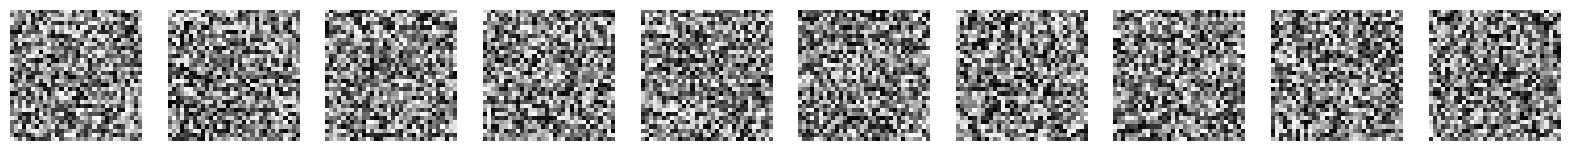

In [23]:
display(start_imgs)

In [24]:
#генерация - это запуск семплера Ланжевена для большого количества шагов с нуля
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

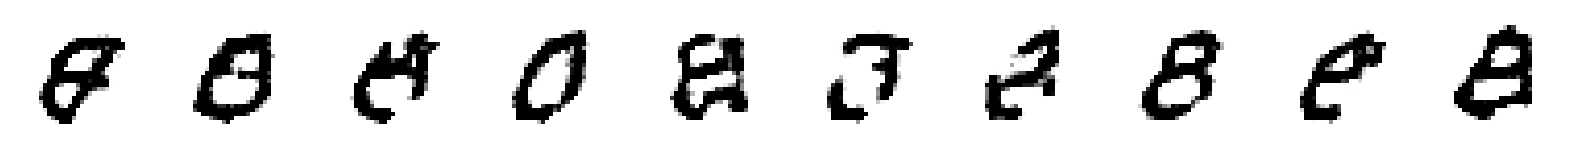

In [25]:
display(gen_img[-1].numpy())

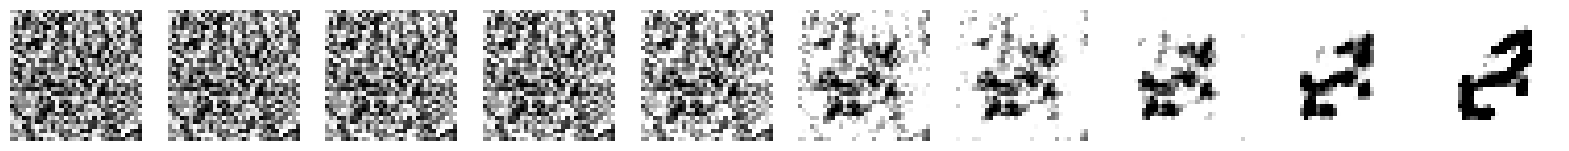

In [26]:
#процесс превращения шума в изображения
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=91321aab-aa91-4889-8ef1-9edef354e364' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>